In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Tetris Bot

In [11]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from tetris.Tetris import Tetris,O

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend() 
if is_ipython:
    from IPython import display

plt.ion()

cuda:0


In [12]:
env = Tetris(pieces=[O])
env.lockout_rate = 0
env.start_drop_rate = 1
env.reset()
BATCH_SIZE = 1024
GAMMA = 0.99
MULISTEP_GAMMA = 0.99

EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 2000000
TARGET_UPDATE = 25
NUM_STATES = len(env.actions)
MULTISTEP_PARAM = 5
MOVEMENT_COST = 0.01
LAYER_HISTORY = 4
TRAIN_RATE = 4
LEARNING_RATE = 5 * 10**-4

steps_done = 0

def curr_eps(steps):
    return 0
#     return EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps / EPS_DECAY)

In [13]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        fleeting_memory = Transition(*args)
        self.memory[self.position] = fleeting_memory
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
    
class BiasedMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.good_memories = []
        self.bad_memories = []
        self.bias = []
        self.bias_sum = 0
        self.position = 0

    def push(self, *args, bias=1):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            self.bias.append(None)
            self.bias_sum += bias
        else:
            # Don't add if small bias
            if bias < self.bias_sum / len(self.memory) * (curr_eps(steps_done) - EPS_END):
                return
            self.bias_sum -= self.bias[self.position]
            self.bias_sum += bias
        self.memory[self.position] = Transition(*args)
        self.bias[self.position] = bias
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, biased=True):
        if biased:
            choice_indices = np.random.choice(len(self.memory), size=batch_size, replace=False, p=np.array(self.bias) / self.bias_sum)
            return [self.memory[i] for i in choice_indices]
        else:
            return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [14]:
class NoisyFactorizedLinear(nn.Linear):
    """
    NoisyNet layer with factorized gaussian noise
    """
    def __init__(self, in_features, out_features, sigma_zero=0.4, bias=True):
        super(NoisyFactorizedLinear, self).__init__(in_features, out_features, bias=bias)
        sigma_init = sigma_zero / math.sqrt(in_features)
        self.sigma_weight = nn.Parameter(torch.Tensor(out_features, in_features).fill_(sigma_init))
        self.register_buffer("epsilon_input", torch.zeros(1, in_features))
        self.register_buffer("epsilon_output", torch.zeros(out_features, 1))
        if bias:
            self.sigma_bias = nn.Parameter(torch.Tensor(out_features).fill_(sigma_init))

    def forward(self, input):
        torch.randn(self.epsilon_input.size(), out=self.epsilon_input)
        torch.randn(self.epsilon_output.size(), out=self.epsilon_output)

        func = lambda x: torch.sign(x) * torch.sqrt(torch.abs(x))
        eps_in = func(self.epsilon_input)
        eps_out = func(self.epsilon_output)

        bias = self.bias
        if bias is not None:
            bias = bias + self.sigma_bias * Variable(eps_out.t())
        noise_v = Variable(torch.mul(eps_in, eps_out))
        return F.linear(input, self.weight + self.sigma_weight * noise_v, bias)

class DQN(nn.Module):
    def __init__(self, h, w, history=LAYER_HISTORY):
        super().__init__()
        self.input_layer_width = h * w
        
        # Encoder section
        layer_widths = [
            1, 
            64,
            64,
            64,
            128,
        ]
#         self.shared_layers = nn.Sequential(
#             nn.Conv2d(layer_widths[0], layer_widths[1], 3, padding=1),
#             nn.BatchNorm2d(num_features=layer_widths[1]),
#             nn.ReLU(),
#             nn.Conv2d(layer_widths[1], layer_widths[2], 3, padding=1),
#             nn.BatchNorm2d(layer_widths[2]),
#             nn.ReLU(),
#             nn.Conv2d(layer_widths[2], layer_widths[3], 3, padding=1),
#             nn.BatchNorm2d(layer_widths[3]),
#             nn.ReLU()
#         )
        self.layer_0 = nn.Conv2d(layer_widths[0], layer_widths[1], 3, padding=1)
        self.layer_1 = nn.BatchNorm2d(num_features=layer_widths[1])
        self.layer_2 = nn.Conv2d(layer_widths[1], layer_widths[2], 3, padding=1)
        self.layer_3 = nn.BatchNorm2d(layer_widths[2])
        self.layer_4 = nn.Conv2d(layer_widths[2], layer_widths[3], 3, padding=1)
        self.layer_5 = nn.BatchNorm2d(layer_widths[3])
        
        # Value Net
        self.value_layer1 = nn.Linear(layer_widths[3] * self.input_layer_width, layer_widths[4])
        self.vbn = nn.BatchNorm1d(layer_widths[4])
        self.value_layer2 = nn.Linear(layer_widths[4], 1)
        
        # Advantage Net
        self.advantage_layer1 = NoisyFactorizedLinear(layer_widths[3] * self.input_layer_width, layer_widths[4])
        self.abn = nn.BatchNorm1d(layer_widths[4])
        self.advantage_layer2 = NoisyFactorizedLinear(layer_widths[4], NUM_STATES)

    def forward(self, x):
        # Encoder
#         x = self.shared_layers(x)
        x1 = F.relu(self.layer_1(self.layer_0(x)))
        x2 = F.relu(self.layer_3(self.layer_2(x1 + x)))
        x3 = F.relu(self.layer_5(self.layer_4(x2 + x1)))
        x = x3.view(x3.size(0), -1)
        
        value = F.relu(self.vbn(self.value_layer1(x)))
        value = self.value_layer2(value)
        
        advg = F.relu(self.abn(self.advantage_layer1(x)))
        advg = self.advantage_layer2(advg)
        
        return  value.expand(-1, NUM_STATES) + (advg - advg.mean(1, keepdim=True))

In [15]:
policy_net.parameters

<bound method Module.parameters of DQN(
  (layer_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (value_layer1): Linear(in_features=12800, out_features=256, bias=True)
  (vbn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (value_layer2): Linear(in_features=256, out_features=1, bias=True)
  (advantage_layer1): NoisyFactorizedLinear(in_features=12800, out_features=256, bias=True)
  (abn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (advantage_layer2): NoisyFact

In [16]:
def create_state(grid, current_piece, next_piece):
    fgrid = np.zeros((20,10))
    for i,row in enumerate(grid):
        for j in range(3,13):
            fgrid[i][j-3] = 1.0 if row & (1<<j) else 0.0
    return fgrid

def get_screen(grid, human=False):
    screen = create_state(grid, None, None)
    
    # Resize and add a batch dimension
    tensor = torch.from_numpy(screen).unsqueeze(0).unsqueeze(0)
    # Push to floats on GPU
    return tensor.type(torch.FloatTensor).to(device)

In [17]:
# Get screen size so that we can initialize layers correctly based on shape
init_screen = get_screen(env.get_grid())
_, _, screen_height, screen_width = init_screen.shape

In [18]:
load_net_prefix = './models/tetrisBotHackedConv2v'
load_net_number = 0
net_to_load = f'{load_net_prefix}{load_net_number}'
try:
    policy_net = torch.load(net_to_load)
    policy_net.eval()
    target_net = torch.load(net_to_load)
    target_net.eval()
    print(f'{net_to_load} loaded...')
except:
    policy_net = DQN(screen_height, screen_width).to(device)
    target_net = DQN(screen_height, screen_width).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    print(f'Fell back to creating a new net...')

Fell back to creating a new net...


In [19]:
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(1000000)

def select_action(state, deterministic=False):
    global steps_done
    sample = random.random()
    eps_threshold = curr_eps(steps_done)
    steps_done += 1
    if sample > eps_threshold and not deterministic:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net.eval()(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(NUM_STATES)]], device=device, dtype=torch.long)


episode_durations = []
lines_cleared = []
eps_values = []

def plot_durations(save=None):
    fig = plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    plt.plot(np.array(lines_cleared) * 50)
#     plt.plot(np.array(eps_values) * 500)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    
    if save is not None:
        fig.savefig(save, bbox_inches='tight')
        
    if is_ipython:
        display.clear_output(wait=True)
        plt.show()

In [20]:
def compute_loss_single(state, action, next_state, reward):
    return _compute_loss(state, action, next_state, reward, batch_size=1)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    next_state_batch = torch.cat(batch.next_state)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    loss = _compute_loss(state_batch, action_batch, next_state_batch, reward_batch)
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def _compute_loss(_state, _action, _next_state, _reward, batch_size=BATCH_SIZE):
    state_action_values = policy_net(_state).gather(1, _action)
    next_state_values = target_net(_next_state)[0][policy_net(_next_state).argmax(1)[0]].detach()
    expected_state_action_values = (next_state_values * GAMMA) + _reward
    return F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

In [30]:
def did_piece_fall(this_env):
    return this_env.placing_frame

def get_height(this_env):
    return np.argmin(this_env._grid[3:] != 57351)

def create_reward(this_env, block_placed, action, is_done,
                  old_height, old_lines, include_height=True, include_score=True):
    if not block_placed:
        # Punish a little for doing something that isn't the empty move, or down
        if action == 0:
            return 0
    if is_done:
        return -10.0
    
    total_reward = 0
    if include_height:
        this_height = get_height(this_env)
        if this_height > old_height: 
            # Punish a little more the closer you are to the top
            total_reward += (1 + this_height / 10) * (old_height - this_height) / 4
    
    line_diff = env._total_lines_cleared - old_lines
    if include_score and line_diff != 0:
        total_reward += 2 ** (line_diff + 1)

    return total_reward
    
def train(num_episodes=1000, human=False): 
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        height, lines = 0, 0
        env.reset()
        last_state = get_screen(env.get_grid(), human=human)
        state = get_screen(env.get_grid(), human=human)
        hole_count = 0 
        hole_reward = 0
        tower_count = 0 
        tower_reward = 0
        if not human:
            state_array = [last_state] * MULTISTEP_PARAM
            reward_array = [0] * MULTISTEP_PARAM
            
            reward_sum = 0
            array_pos = 0
            next_array_pos = 1
            warmup = 1
        for t in count():

            # Select and perform an action
            action = select_action(state, deterministic=human)
            # Can only perform an action once every three frames anyway...
            state, _, done = env.step(action.item())
            piece_fell = did_piece_fall(env)
#             if not done:
#                 state, _, done = env.step(0)
#                 piece_fell = (piece_fell or did_piece_fall(env))
#             if not done:
#                 state, _, done = env.step(0)
#                 piece_fell = (piece_fell or did_piece_fall(env))

            # Observe new state
            state = get_screen(state, human)
            
            if not human:
                state_array[array_pos] = state
            
                reward_single = create_reward(env, piece_fell, action, done, height, lines)
                reward_sum = (MULISTEP_GAMMA * reward_sum) + reward_single - (MULISTEP_GAMMA ** MULTISTEP_PARAM) * reward_array[array_pos]
                reward_array[array_pos] = reward_single
                reward_sum = torch.tensor([reward_sum], device=device).type(torch.float)
                
                # Store the transition in memory
                if warmup > MULTISTEP_PARAM:
#                     with torch.no_grad():
#                         loss = compute_loss_single(state_array[next_array_pos], action, state, reward_sum) ** ((1 - curr_eps(steps_done)) / 2 + 0.05)
#                     memory.push(state_array[next_array_pos], action, state, reward_sum, bias=np.array([loss.cpu()])[0])
                    memory.push(state_array[next_array_pos], action, state, reward_sum)
                
                # Perform one step of the optimization (on the target network)
                if (warmup + 1) % TRAIN_RATE == 0:
                    optimize_model()
                if done:
                    episode_durations.append(t + 1)
                    lines_cleared.append(lines)
                    eps_values.append(curr_eps(steps_done))
                    plot_durations('latestConv.png')
                    break

            else:
                if done:
                    break

            # Set up params for next cycle
            height = get_height(env)
            lines = env._total_lines_cleared
            last_state = state
            if not human:
                array_pos = (array_pos + 1) % MULTISTEP_PARAM
                next_array_pos = (next_array_pos + 1) % MULTISTEP_PARAM
                warmup += 1
            
        if not human:
            # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

def watch_model(rounds=1000):
    with torch.no_grad():
        train(rounds, human=True)

tensor([[3]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[3]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[3]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[5]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[3]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[3]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[3]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[3]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[3]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[5]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[3]], device='cuda:0') 0 tensor([0.], device='cuda:0')
tensor([[6]], device='cuda:0') -0.6 tensor([-0.6000], device='cuda:0')
tensor([[6]], device='cuda:0') -0.7 tensor([-1.2940], device='cuda:0')
tensor([[5]], device='cuda:0') 0 tensor([-1.2811], device='cuda:0')
tensor([[5]], device='cuda:0') 0 tensor([-1.2682], device='cuda:0')
tensor([[3]], device='cuda:0'

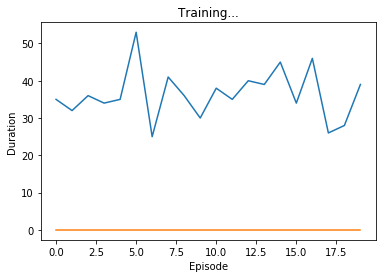

In [28]:
# Testing
train(5)

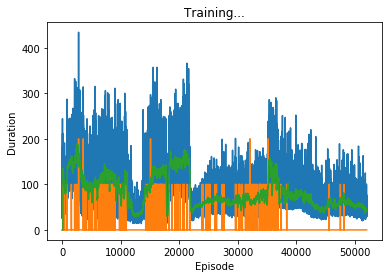

In [ ]:
idx = 6
while True:
    train(5000)
    torch.save(policy_net, f'{load_net_prefix}{idx}')
    idx += 1

In [26]:
2560000 / policy_net.input_layer_width / 64

200.0

In [20]:
idx

68

In [53]:
torch.save(policy_net, f'{load_net_prefix}{idx}')

/home/kaimyn/.local/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kaimyn/.local/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type NoisyFactorizedLinear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [33]:
action_func = lambda e: policy_net.eval()(get_screen(e.get_grid())).max(1)[1].view(1, 1).squeeze().item()

In [34]:
from tetris.Tetris import watch_bot_tetris

In [35]:
watch_bot_tetris(action_func, pieces=[O])

.  .  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
O  O  .  .  .  .  .  .  .  .
O  O  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
.  O  O  .  .  .  .  .  .  .
.  O  O  .  .  .  .  .  .  .
.  O  O  .  .  .  .  .  .  .
.  O  O  .  .  .  .  .  .  .
.  .  O  O  .  .  .  .  .  .
.  .  O  O  .  .  .  .  .  .
.  .  .  O  O  .  .  .  .  .
.  .  .  O  O  .  .  .  .  .
O  O  .  O  O  .  .  .  .  .
O  O  .  O  O  .  .  .  .  .


KeyboardInterrupt: 